In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

# Getting started with JAX and DALI

This tutorial shows how to use DALI with JAX. It demonstrates how to use DALI iterators as a data source for JAX workflows.

### Running DALI with JAX

In [2]:
import nvidia.dali.fn as fn

image_dir = "../../data/images"


def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs)
    images = fn.resize(images, resize_x=256, resize_y=256)

    return images, labels


This function defines the following preprocessing pipline:
 - read raw JPEGs and labels from the hard drive
 - decode JPEGs to RGB format
 - resize decoded images to 256x256 size

 Test data used for this example can be found in [DALI Github page](https://github.com/NVIDIA/DALI/tree/main/docs/examples/data/images).

In [3]:
from nvidia.dali.plugin.jax import data_iterator

iterator_fn = data_iterator(
    simple_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader")

iterator = iterator_fn(batch_size=1, num_threads=1, device_id=0)

We can use the iterator to get the batch. The batch is a dictionary with the keys defined in the `output_map` argument. The values are JAX arrays.

In [4]:
batch = next(iterator)

print(type(batch["images"]))
print(batch['images'].shape)
print(type(batch["labels"]))
print(batch['labels'].shape)


<class 'jaxlib.xla_extension.ArrayImpl'>
(1, 256, 256, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>
(1, 1)


To visualize the outputs we create a simple function to print the images using matplotlib.

In [5]:
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image)

We can now use it to inspect the content of the batch:

Lablel = [0]


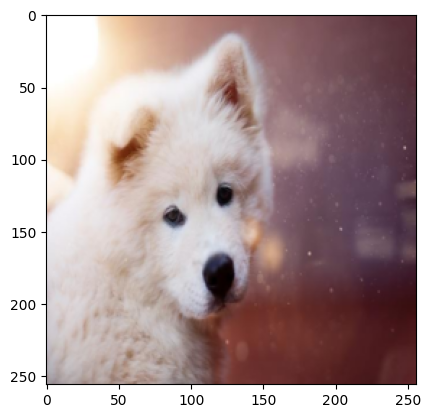

In [6]:
images = batch["images"]
show_image(images[0])
print(f'Lablel = {batch["labels"][0]}')

We can continue to run the iterator and get the next batch:

Lablel = [0]


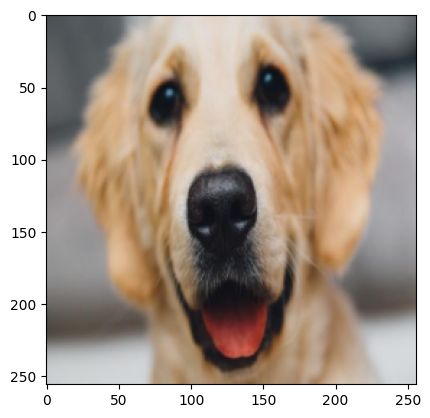

In [7]:
batch = next(iterator)

images = batch["images"]
show_image(images[0])
print(f'Lablel = {batch["labels"][0]}')

### Batching

For now we returned only one sample per `next` call. We can use the same function to create an iterator returning actual batch of data containing multiple samples.

In [8]:
iterator = iterator_fn(batch_size=8, num_threads=1, device_id=0)

In [9]:

batch = next(iterator)

print(type(batch["images"]))
print(batch['images'].shape)
print(type(batch["labels"]))
print(batch['labels'].shape)

<class 'jaxlib.xla_extension.ArrayImpl'>
(8, 256, 256, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>
(8, 1)


We can adjust the `show_image` function to plot the whole batch:

In [10]:
from matplotlib import gridspec

def show_image(images):
    columns = 4
    rows = (images.shape[0] + 1) // (columns)
    plt.figure(figsize = (24,(24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images[j])

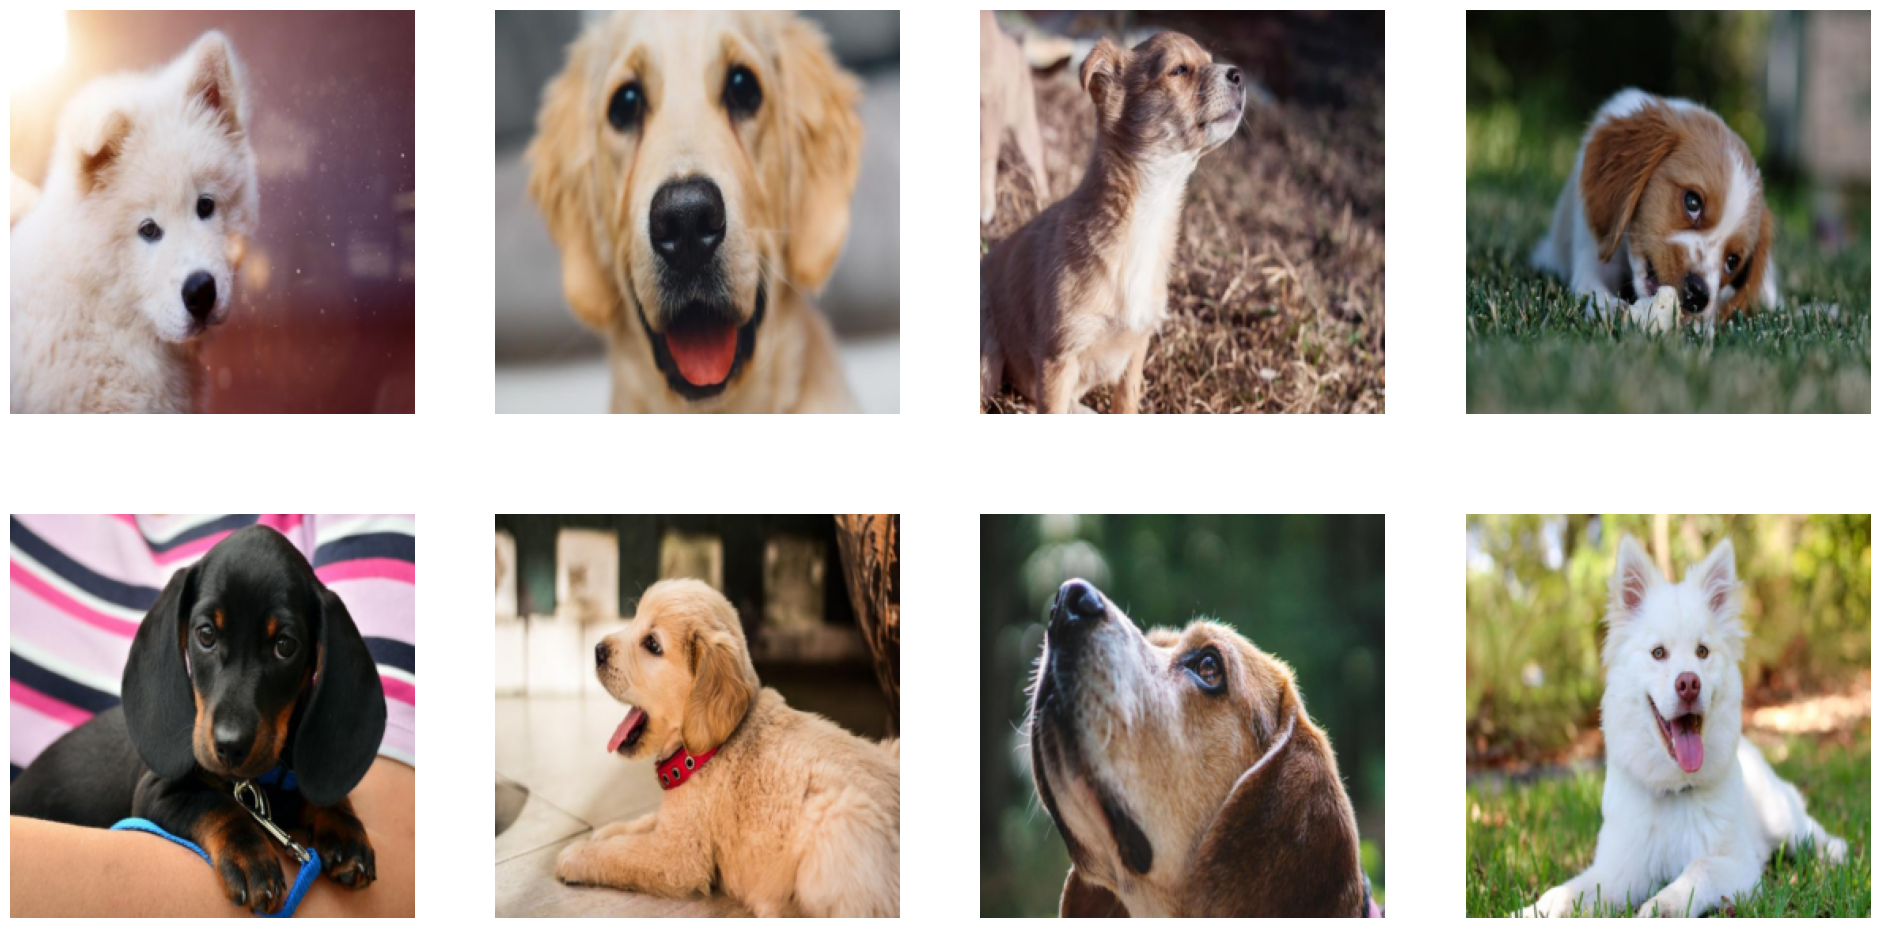

In [11]:
show_image(batch["images"])

### GPU acceleration

For now the preprocessing was using only the CPU. Note the backend of the output Jax arrays:

In [12]:
print(f'Images backing device: {batch["images"].device()}')

Images backing device: TFRT_CPU_0


In [13]:
def simple_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs)
    images = images.gpu()
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

In [14]:
iterator_gpu_fn = data_iterator(
    simple_gpu_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader")

iterator_gpu = iterator_gpu_fn(batch_size=8, num_threads=1, device_id=0)

In [15]:
batch = next(iterator_gpu)

print(f'Images backing device: {batch["images"].device()}')
print(f'Labels backing device: {batch["labels"].device()}')

Images backing device: cuda:0
Labels backing device: TFRT_CPU_0


### Hardware accelerated decoding

In [16]:
def simple_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

In [17]:
iterator_gpu_fn = data_iterator(
    simple_gpu_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader")

iterator_gpu = iterator_gpu_fn(batch_size=8, num_threads=1, device_id=0)

In [18]:
batch = next(iterator_gpu)

print(f'Images backing device: {batch["images"].device()}')
print(f'Labels backing device: {batch["labels"].device()}')

Images backing device: cuda:0
Labels backing device: TFRT_CPU_0


### Augmentations

In [19]:
def simple_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    images = fn.rotate(images, angle=angle, fill_value=0)
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels



In [20]:
iterator_gpu_fn = data_iterator(
    simple_gpu_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader")

iterator_gpu = iterator_gpu_fn(batch_size=8, num_threads=1, device_id=0)

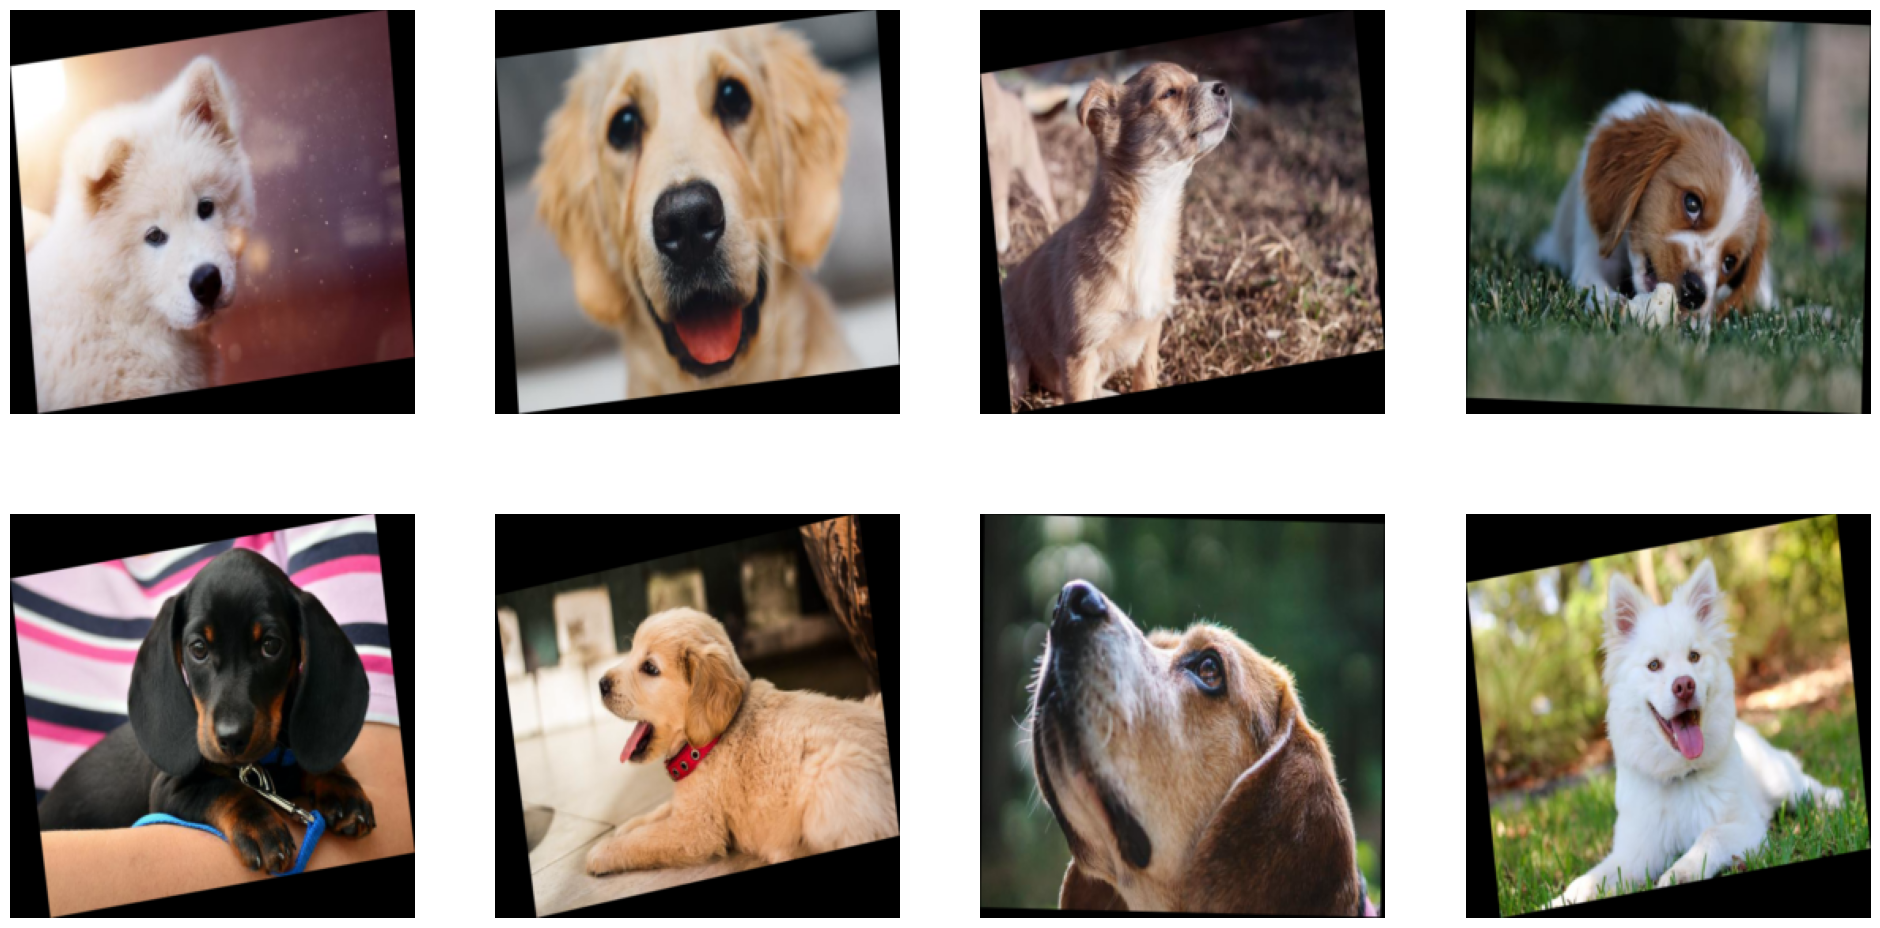

In [21]:
batch = next(iterator_gpu)
show_image(batch["images"])

### Multiple GPUs

In [22]:
import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding

mesh = Mesh(jax.devices(), axis_names=('batch'))
sharding = NamedSharding(mesh, PartitionSpec('batch'))

In [23]:
def simple_gpu_pipeline(num_shards=1, shard_id=0):
    jpegs, labels = fn.readers.file(
        file_root=image_dir, name="image_reader", num_shards=num_shards, shard_id=shard_id)
    images = fn.decoders.image(jpegs, device="mixed")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    images = fn.rotate(images, angle=angle, fill_value=0)
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels.gpu()

In [24]:
iterator_gpu_fn = data_iterator(
    simple_gpu_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader", 
    sharding=sharding)

iterator_gpu = iterator_gpu_fn(batch_size=8, num_threads=1)

In [25]:
batch = next(iterator_gpu)

print(f'Images backing device: {batch["images"].devices()}')
jax.debug.visualize_array_sharding(batch["images"].ravel())

Images backing device: {cuda(id=1), cuda(id=0)}


  GPU 0    GPU 1  
                  

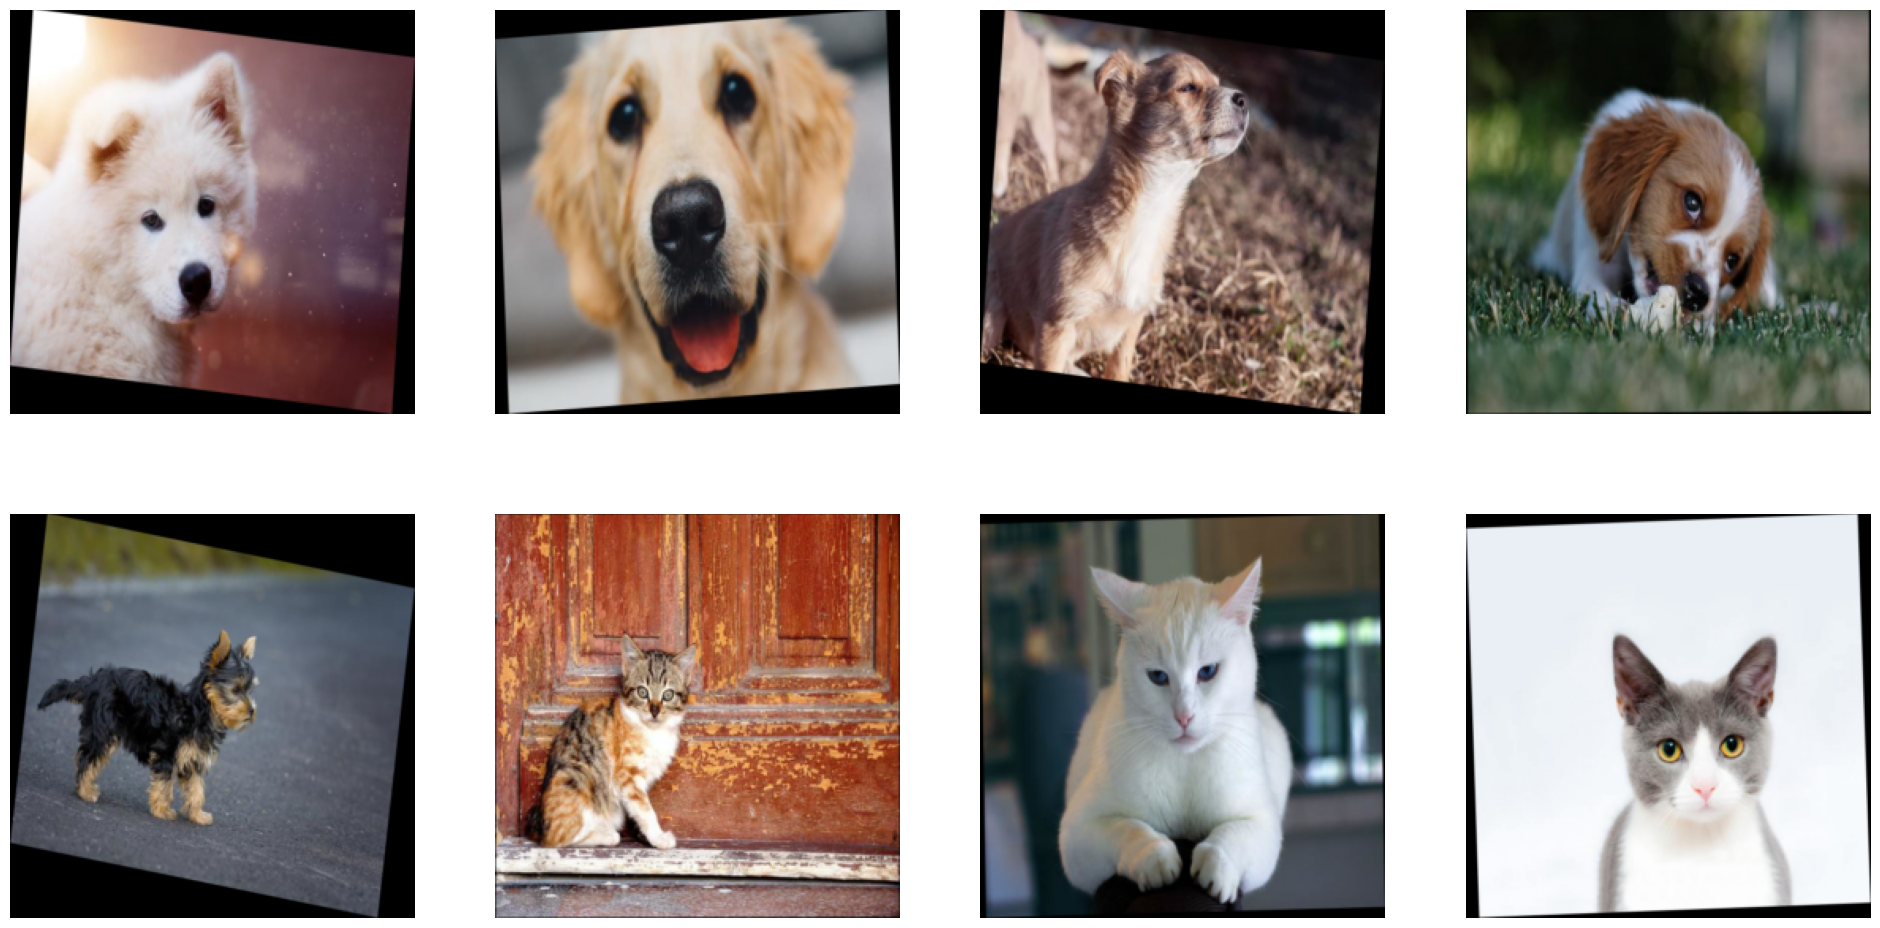

In [26]:
show_image(batch["images"])

### Technical details

In [27]:
print(type(iterator))

<class 'nvidia.dali.plugin.jax.iterator.DALIGenericIterator'>


In [28]:
from nvidia.dali.pipeline import pipeline_def

@pipeline_def
def simple_gpu_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels.gpu()

pipeline = simple_gpu_pipeline(batch_size=8, num_threads=1, device_id=0)

print(type(pipeline))

<class 'nvidia.dali.pipeline.Pipeline'>


In [29]:
from nvidia.dali.plugin.jax import DALIGenericIterator

iterator = DALIGenericIterator(pipeline, output_map=["images", "labels"], reader_name="image_reader")

In [30]:
batch = next(iterator)

print(f'Images backing device: {batch["images"].device()}')
print(f'Labels backing device: {batch["labels"].device()}')

Images backing device: cuda:0
Labels backing device: cuda:0


### Where to go next